In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import functools
import json

### Intro
Dans ce notebook, j'ai cherché à visualiser la répartition de la réutilisation des process dans snakemake pour trois métriques : "tools", "levenshtein" n-gram. 
* "levenshtein" est calculée comme suit, avec d = max(len(p1),len(p2)) : l(p1,p2) = (d-levenshtein(p1,p2))/d. C'est une normalisation qui nous permet d'avoir une mesure de similarité à partir d'une mesure de distance d'édition.
é
Pour obtenir les groupes de process similaires avec levenshtein, nous avons forcé la transitivité si l(p1,p2)>90% et l(p2,p3)>90%, p1,p2 et p3 sont dans le même groupe.
Ces calculs ont été effectués sur une base de processus snakemake contenant au moins un outil.
Ces calculs ont été effectués dans d'autres scripts : ils sont longs à effectuer (>3j pour 6500 process snk).

In [2]:
def importing_json_files(file_wf):
    f_wf = open(file_wf) #informations for nf
    # returns JSON object as
    # a dictionary
    wf = json.load(f_wf)
    f_wf.close
    return wf

#importing the wf and auth dict (github info)
dict_nf = importing_json_files('../json/wf_new_crawl_nextflow.json')
auth_nf = importing_json_files('../json/author_clem_nf.json')

#import processes dictionnaries
with open('/home/marinedjaffardjy/Documents/Code/Similarite_process/json/nf_proc_tool_shell.json') as f:
    nf_proc = json.load(f)

In [3]:
#importing the similarity groups df

nf_json = importing_json_files("/home/marinedjaffardjy/Documents/Code/Similarite_process/json/sim_nf_lev_shell.json")
df_nf_proc= pd.DataFrame(nf_json)
#Nextflow
df_nf = pd.read_csv("../csv/sim_nf_lev_shell.csv")
df_nf_lev_wf = pd.read_csv("../csv/sim_nf_lev_shell_wf.csv")

#Nf-core

nf_non_nfc_json = importing_json_files("/home/marinedjaffardjy/Documents/Code/Similarite_process/json/sim_nf_lev_shell_non_nfc.json")
df_nf_non_nfc_proc= pd.DataFrame(nf_non_nfc_json)
df_nf_lev_non_nfc = pd.read_csv("../csv/sim_nf_lev_shell_non_nfc.csv")
df_nf_lev_non_nfc_wf = pd.read_csv("../csv/sim_nf_lev_shell_non_nfc_wf.csv")

nf_nfc_json = importing_json_files("/home/marinedjaffardjy/Documents/Code/Similarite_process/json/sim_nf_lev_shell_nfc.json")
df_nf_nfc_proc= pd.DataFrame(nf_nfc_json)
df_nf_lev_nfc = pd.read_csv("../csv/sim_nf_lev_shell_nfc.csv")
df_nf_lev_nfc_wf = pd.read_csv("../csv/sim_nf_lev_shell_nfc_wf.csv")

### Réutilisation des process

Regardons la répartition de la réutilisation des process selon les différentes métriques :
- fréquence de réutilisation des process (combien de process sont utilisés n fois ?)
- dans combien de workflows les process sont ils utilisés ?

Note : On calcule ces métriques sur la base complète de workflows et sur la base de workflows uniques

In [4]:
def disp_fig_props_wf(df,sys):
    df_tot =df[df["nb_wf"]>1]
    df_tot = df_tot.sort_values(by="nb_wf")
    fig = df_tot.plot(x="nb_wf",y=["prop_proc"], kind="bar", color = ['blue'], label = ['lev'])
    fig.set_xticklabels(fig.get_xticklabels(), rotation=80, size=5)
    fig.set_xlabel("Number of wf used in with the metric 'levenshtein' in "+sys)
    fig.set_ylabel('Percent of proc')
    fig.legend(loc='best')
    fig.set_yscale('log')
    plt.show()
    plt.rcParams['figure.dpi'] = 500
    plt.rcParams['savefig.dpi'] = 500
    return fig

In [5]:
def disp_single_metric(df,metric,sys,name):
    df=df.sort_values(by=[metric])
    fig2 = df.plot(x=metric,y="prop_proc", kind="bar", color = 'green', label = name)
    fig2.set_xticklabels(fig2.get_xticklabels(), rotation=80, size=5)
    fig2.set_xlabel("""Number of times used with the metric """+ name +"""' in """+sys)
    fig2.set_ylabel('Percent of processors')
    fig2.legend(loc='best')
    #fig2.set_yscale('log'
    plt.show()
    plt.rcParams['figure.dpi'] = 500
    plt.rcParams['savefig.dpi'] = 500
    return fig2

In [6]:
def display_fig_stats_metric(df_sim_lev,sys,metric):
    ax = df_sim_lev.sort_values(by=["nb_reuse"], ascending = False).plot(x='Unnamed: 0', y="nb_reuse", kind="bar", label = "times used "+metric, color = "red")
    ax.set_title("Usage count of processors for metric "+ metric+ " for "+sys) 
    plt.xticks([])
    #ax.set_xticklabels(l, rotation=80, size=5)
    ax.set_xlabel("Distinct processors")
    ax.set_ylabel("Nb of times used")
    plt.rcParams['figure.dpi'] = 500
    plt.rcParams['savefig.dpi'] = 500


In [7]:
def disp_fig_props(df,sys):
    df_tot =df[df["nb_reuse"]>1]
    fig = df_tot.plot(x="nb_reuse",y=["prop_proc"], kind="bar", color = ['orange'], label = ['lev'])
    fig.set_xticklabels(fig.get_xticklabels(), rotation=80, size=5)
    fig.set_xlabel("Number of times used with the metric 'levenshtein' in "+sys)
    fig.set_ylabel('Percent of proc ')
    fig.legend(loc='best')
    fig.set_yscale('log')
    plt.show()
    plt.rcParams['figure.dpi'] = 1000
    plt.rcParams['savefig.dpi'] = 1000
    return fig

In [8]:
def display_proportions_figure(df_init):
    # découpage du wor
    df = df_init[df_init["nb_reuse"]>1]
    fig_4 = df.plot(x="nb_reuse", y=["prop_proc", "prop_wf", 'prop_own'], kind="bar", color = ['orange','blue','red'], label = ['times used','workflows', 'authors'])
    fig_4.set_xticklabels([int(el) for el in df["nb_reuse"]], rotation=45, size=5)
    fig_4.set_xlabel('Number of times used/workflows used in/authors used by')
    fig_4.set_ylabel('Percent of processors')
    fig_4.legend(loc='best')
    fig_4.set_yscale('log')
    plt.show()
    plt.rcParams['figure.dpi'] = 500
    plt.rcParams['savefig.dpi'] = 500
    
    return fig_4

In [9]:
df_nf[df_nf["nb_reuse"]>1].head()

,Unnamed: 0,nb_reuse,nb_proc,prop_proc,nb_own,prop_own,nb_wf,prop_wf
1,1,2.0,649.0,11.521392,452.0,8.024143,478.0,8.485709
2,2,3.0,180.0,3.195455,66.0,1.171667,152.0,2.698385
3,3,4.0,70.0,1.242677,39.0,0.692349,55.0,0.976389
4,4,5.0,36.0,0.639091,29.0,0.514823,26.0,0.461566
5,5,6.0,32.0,0.568081,18.0,0.319546,26.0,0.461566


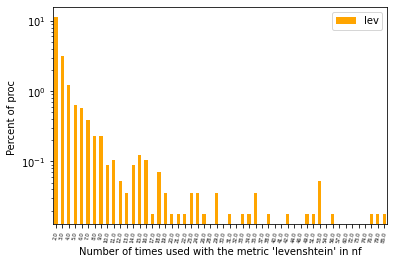

In [10]:
fig_nf = disp_fig_props(df_nf,'nf')

In [11]:
a = df_nf[df_nf["nb_reuse"]==1]["prop_proc"]
100-a

0    19.208237
Name: prop_proc, dtype: float64

In [12]:
max(df_nf['nb_reuse'])

85.0

## Réutilisation des process au sein des workflows

Regardons maintenant répartition de la réutilisation des process au sein des workflows : combien de process sont réutilisés dans x workflow ?
(nb : les workflows sont considérés comme uniques)

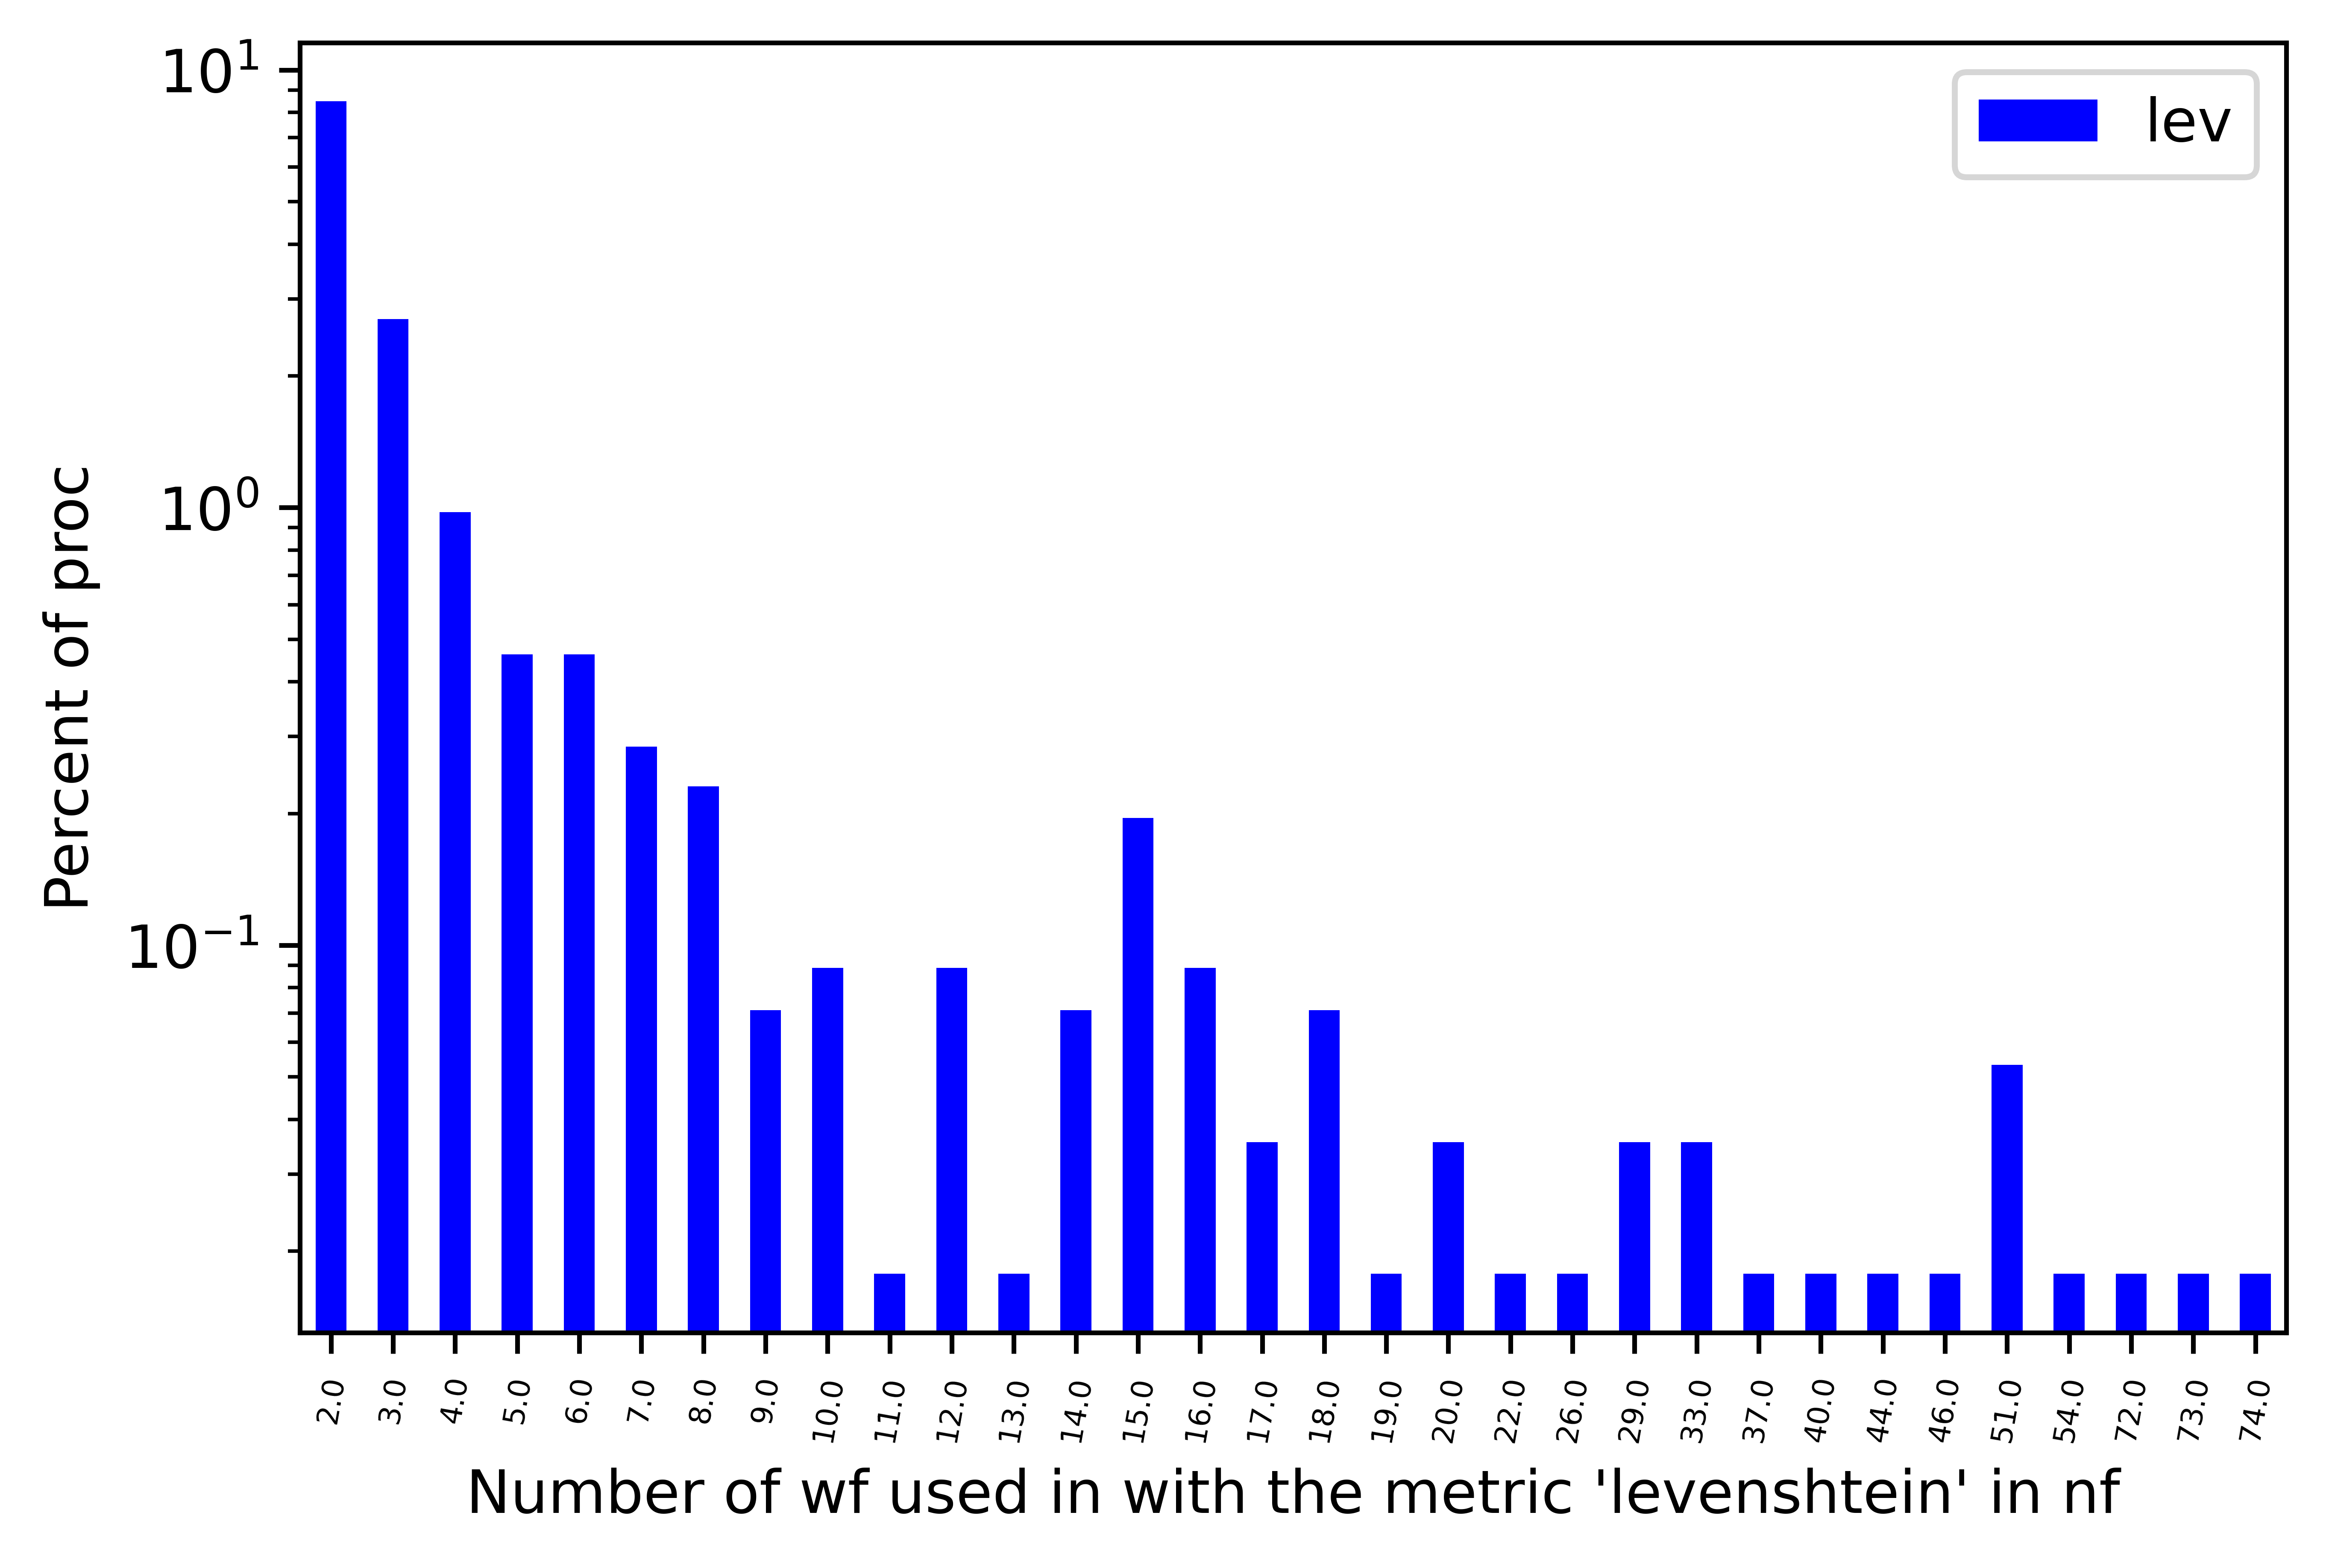

In [13]:
fig_nf_wf = disp_fig_props_wf(df_nf_lev_wf,'nf')

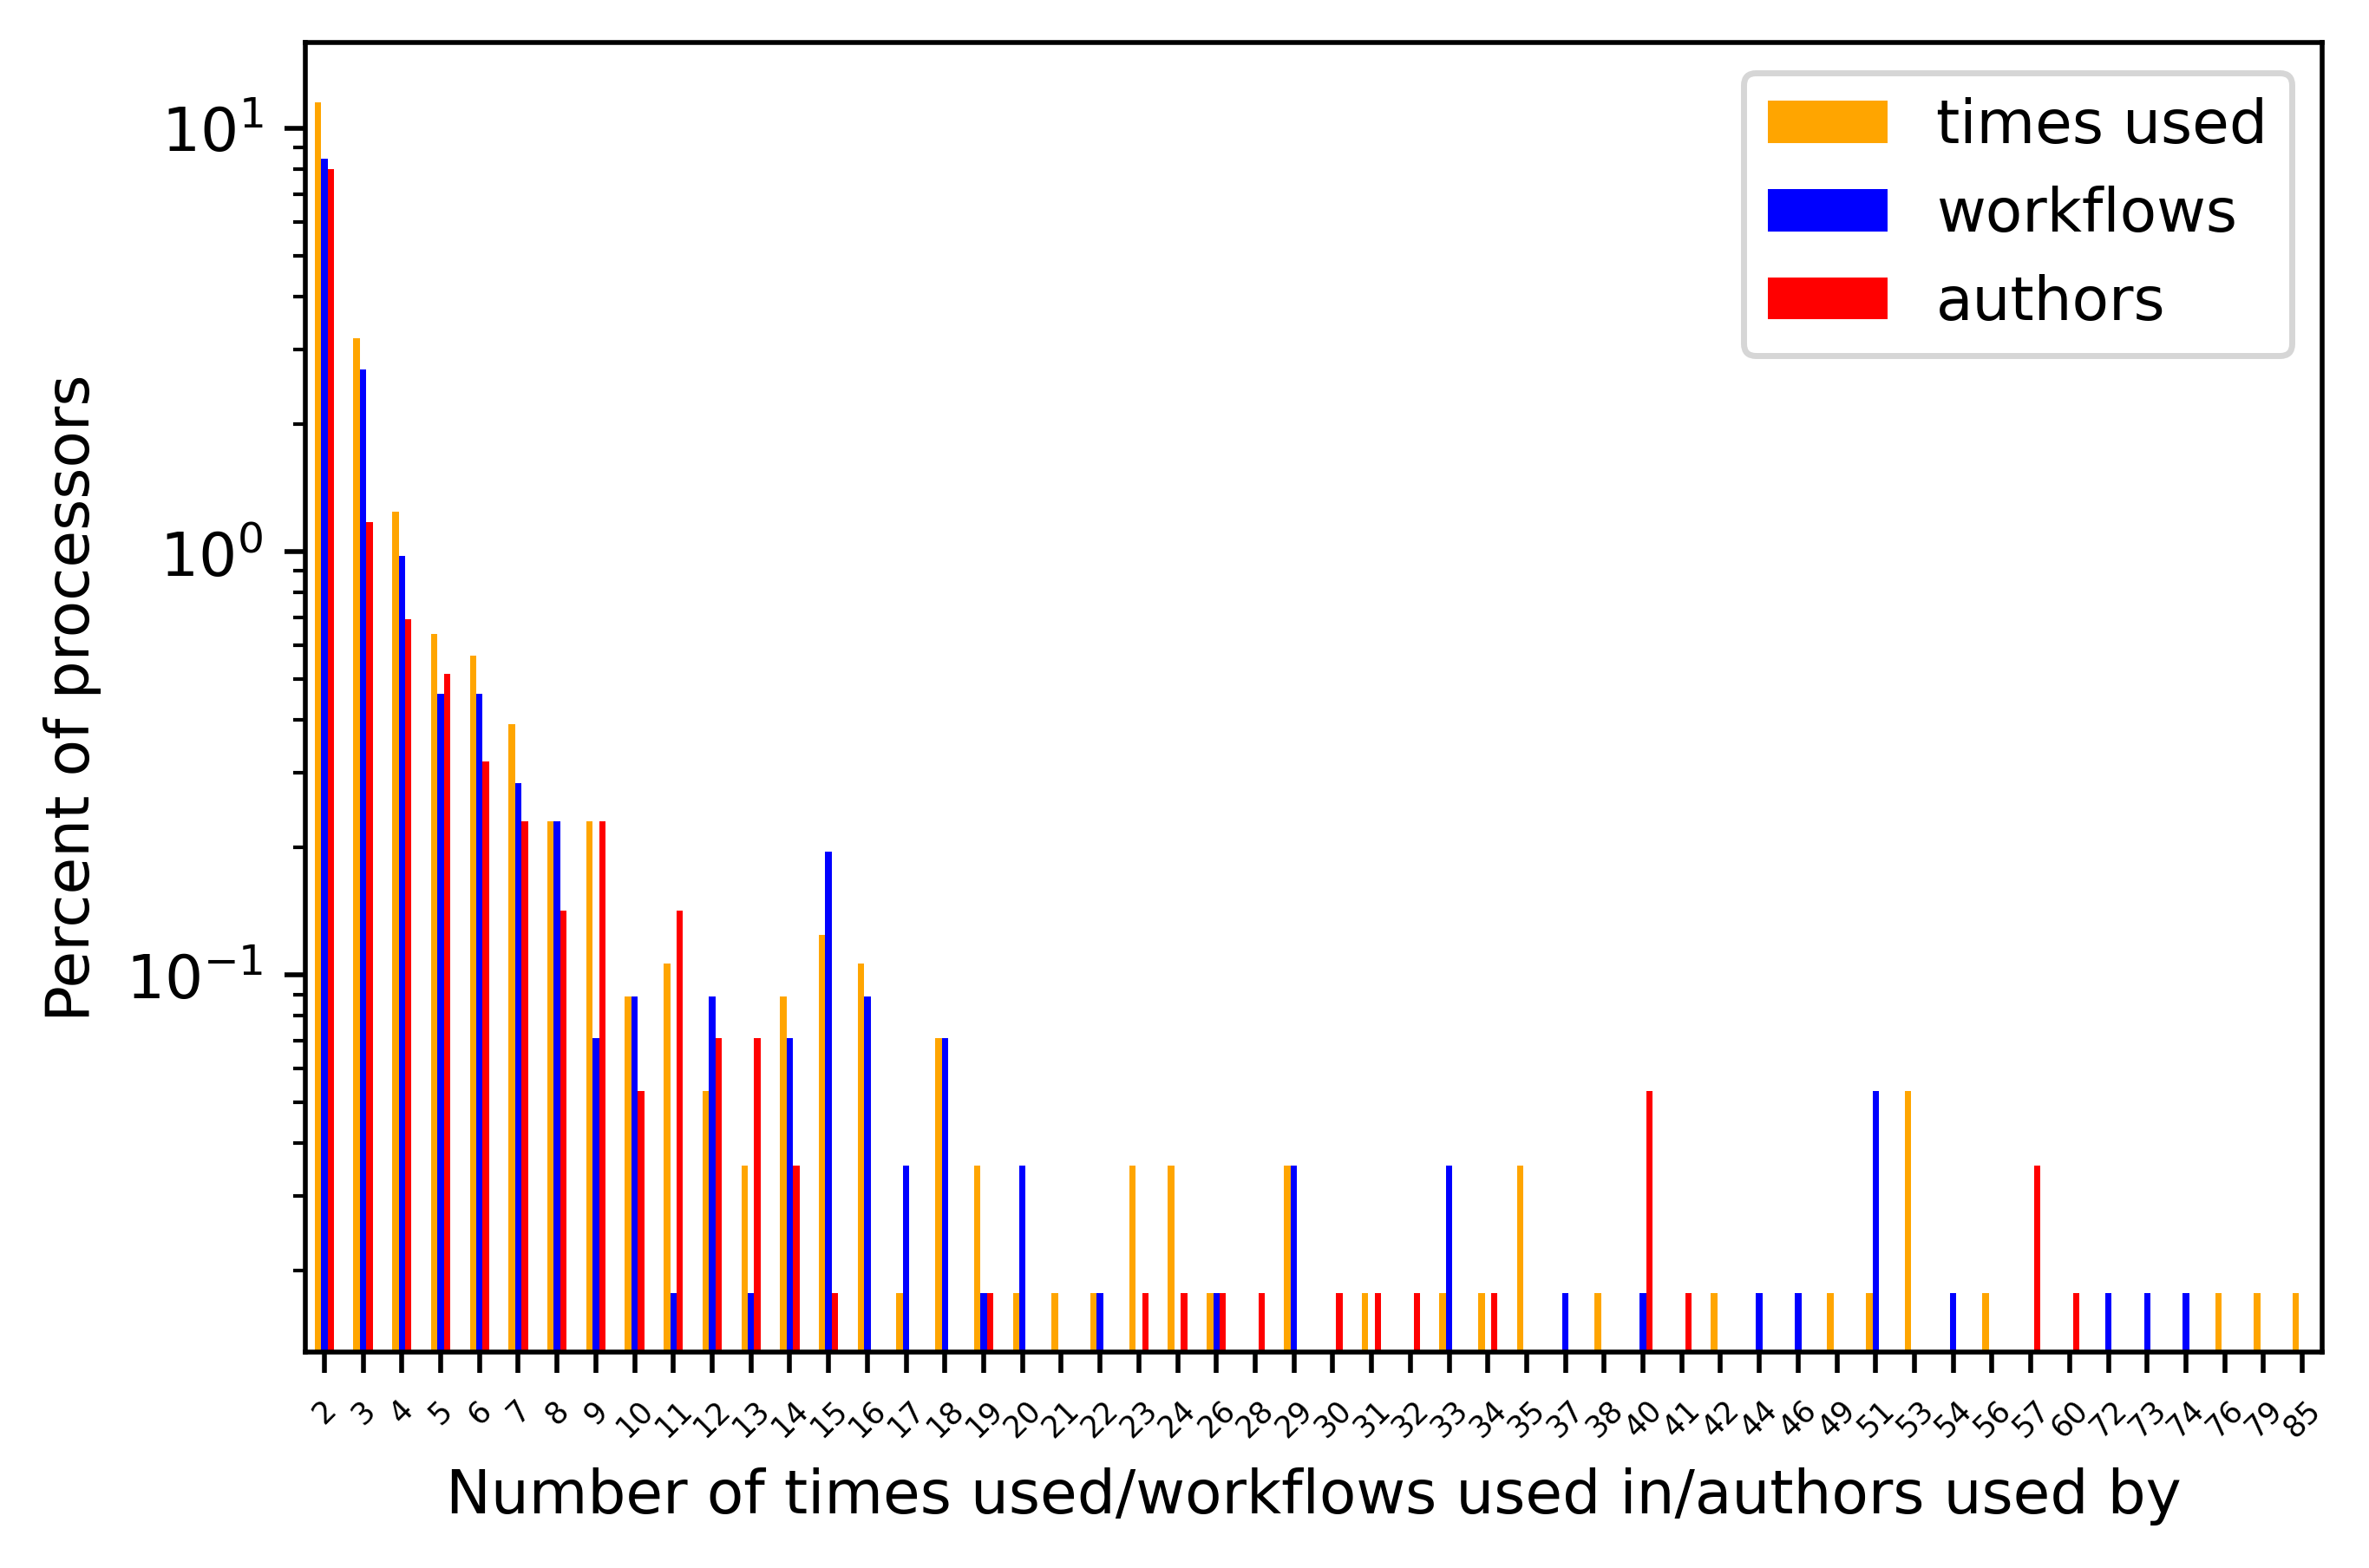

In [14]:
fig_nf_all = display_proportions_figure(df_nf)


### Répartition de la réutilisation des process

Combien de fois chaque process est il réutilisé ?

Répartition de la réutilisation des process pour les métriques "tools" and "levenshtein" pour snakemake

In [15]:
def display_fig_stats_process(df_sim, nb_proc, sys):
    df_sim_s = df_sim.sort_values(by=["nb_reuse"], ascending = False)
    df_sim_s['index'] = df_sim_s.index
    df_sim_s = df_sim_s.head(nb_proc)
    print(len(df_sim_s))
    ax = df_sim_s.plot(x='index', y="nb_reuse", kind="bar", label = "times used", color = "orange")
    ax.set_title('Usage count of the '+str(nb_proc)+' most used processors for metric levenshtein in '+sys) 
    plt.xticks([])
    #ax.set_yscale('log')
    #l=[]
    #for i in range(0,len(df_sim_s)):
        #l.append("p_"+str(i))
    #ax.set_xticklabels(l, rotation=80, size=5)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=80, size=5)
    ax.set_xlabel("Distinct processors")
    ax.set_ylabel("Nb of times used")
    plt.rcParams['figure.dpi'] = 500
    plt.rcParams['savefig.dpi'] = 500
    return ax

150


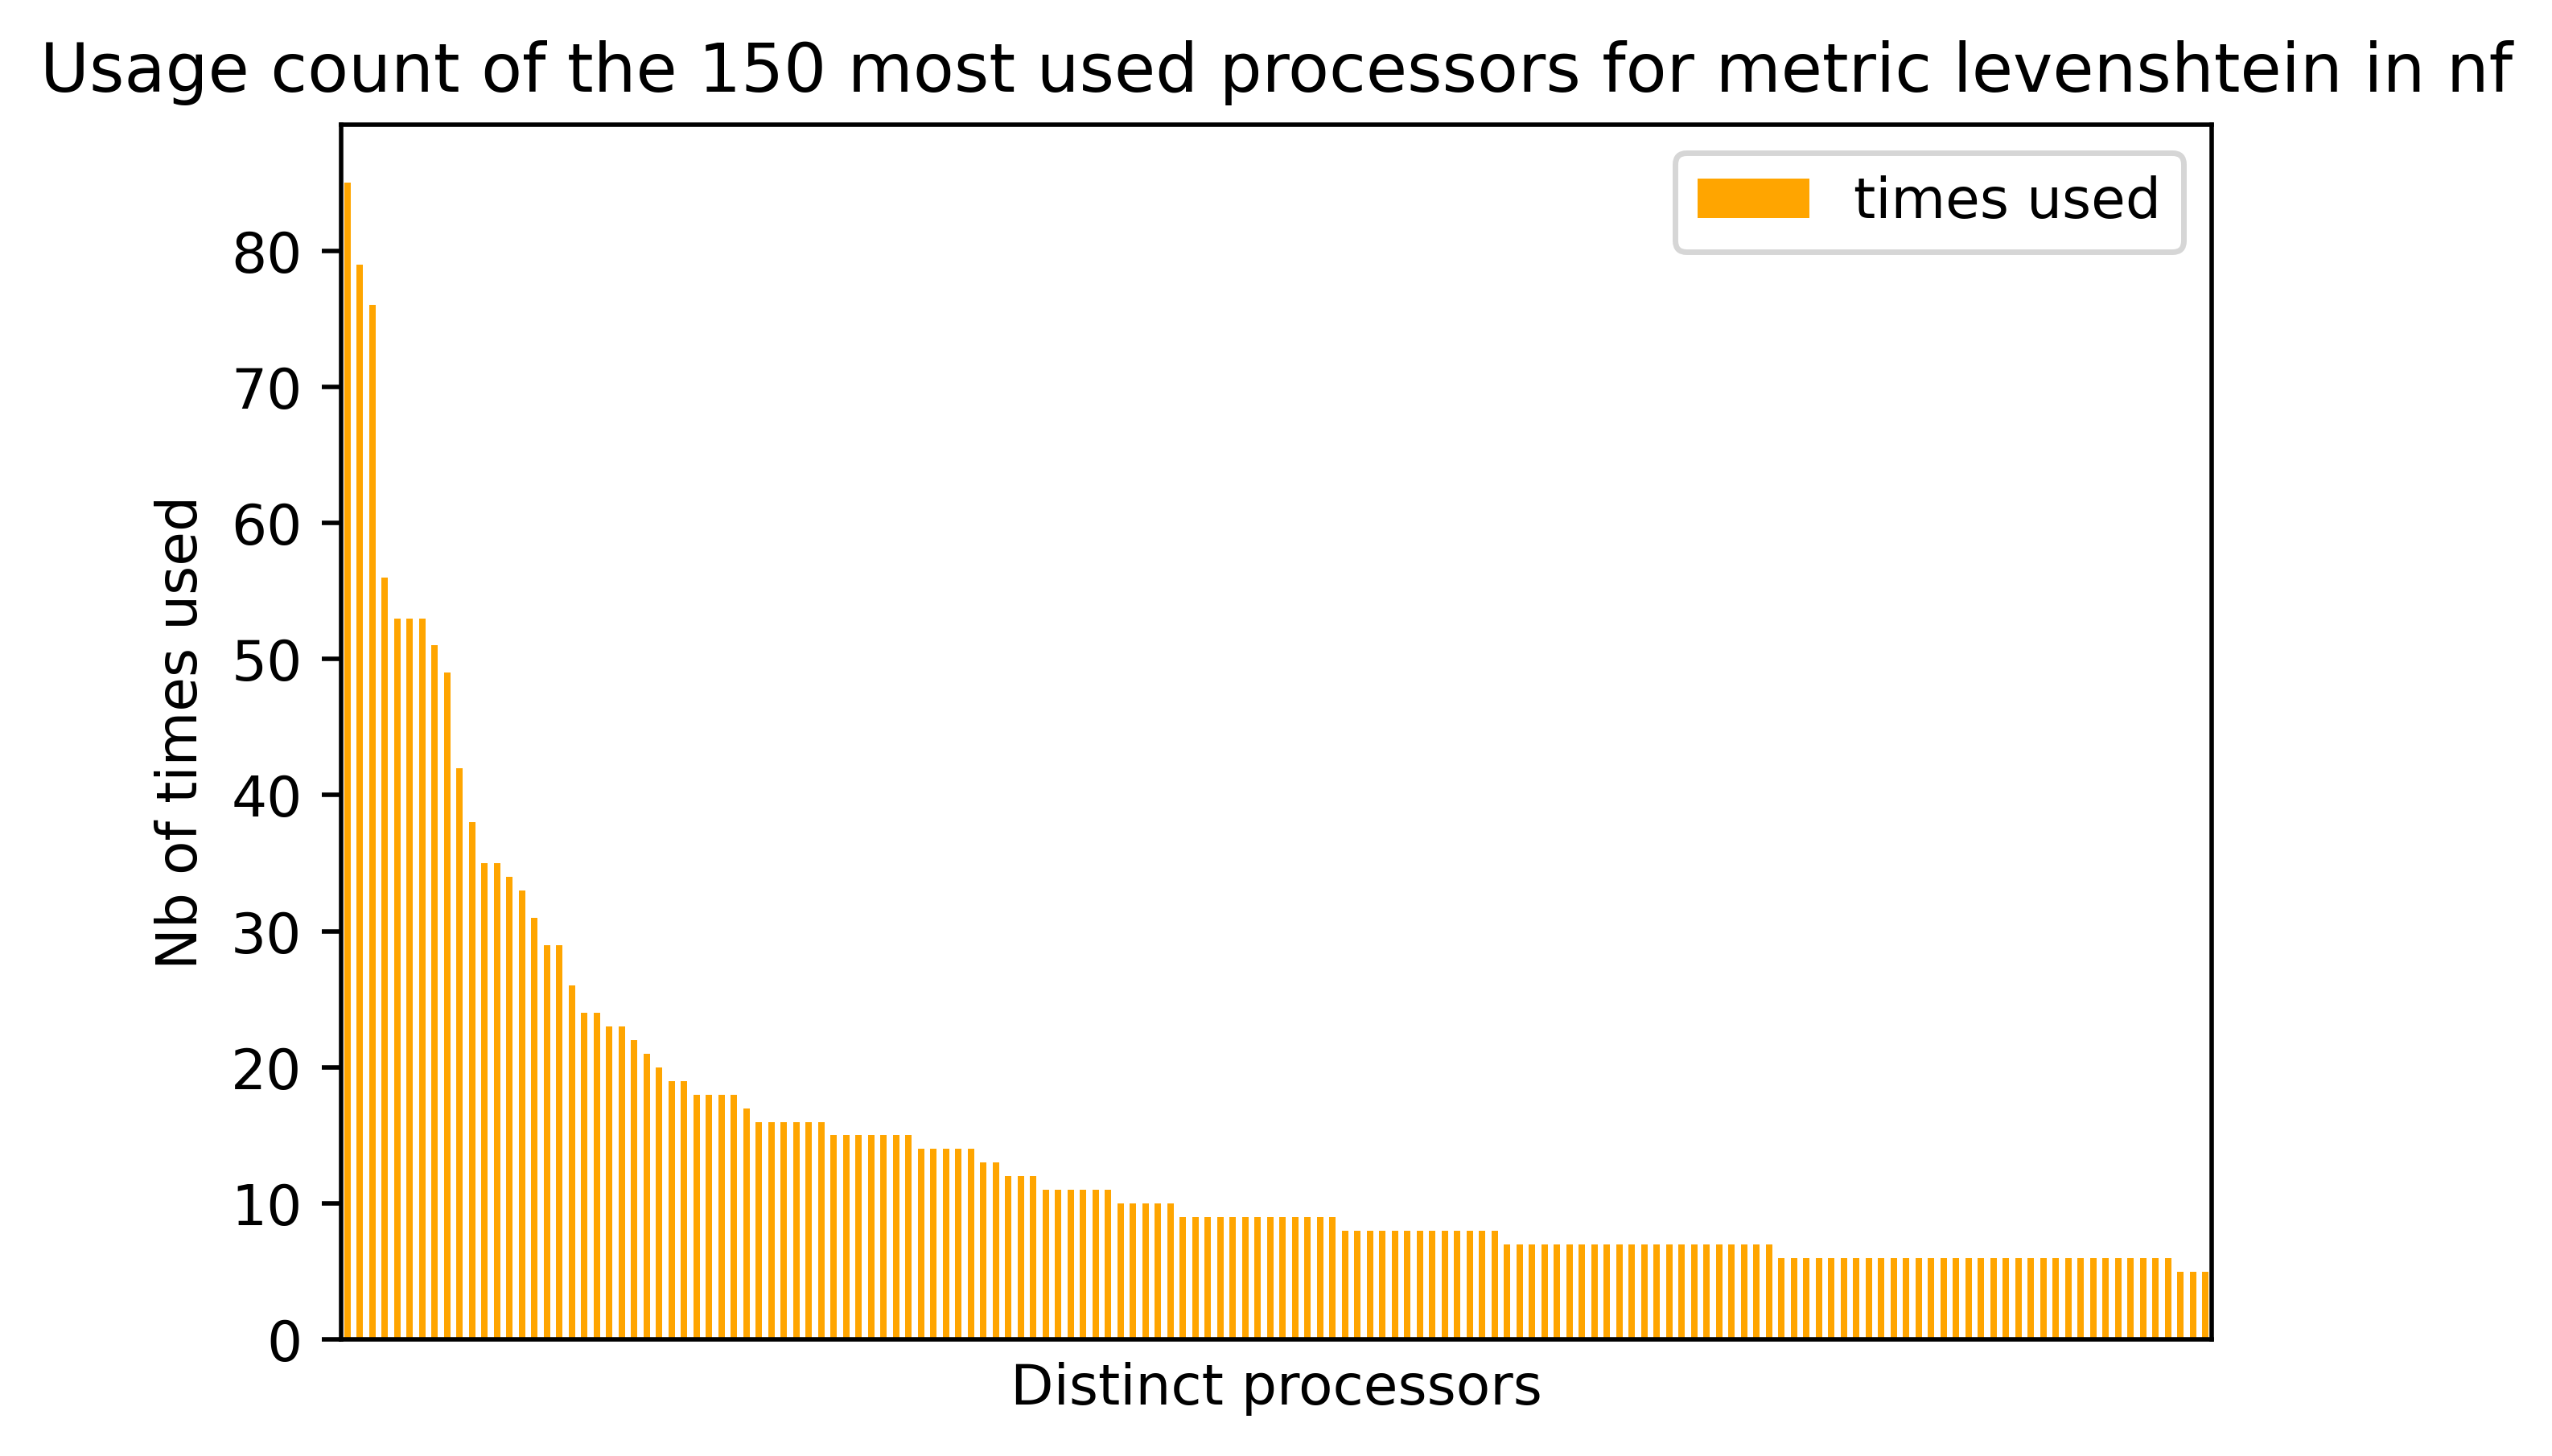

In [16]:
fig_nf = display_fig_stats_process(df_nf_proc,150,"nf")

## Zoom sur la réutilisation de nf-core

On cherche à savoir comment les process nf-core sont réutilisés :
* au sein de nf-core
* dans tous les workflows nf non nf-core


In [17]:
def disp_fig_props_nfc(df,sys,proc):
    df_tot=df[df["nb_reuse"]>1]
    fig = df_tot.plot(x="nb_reuse",y=["prop_proc_nfc","prop_proc_non_nfc"], kind="bar", color = ['blue','green'], label = ['nfc','non_nfc'])
    fig.set_xticklabels(fig.get_xticklabels(), rotation=80, size=5)
    fig.set_xlabel("Number of times used with the metric 'levenshtein' by "+sys)
    fig.set_ylabel('Percent of '+proc)
    fig.legend(loc='best')
    fig.set_yscale('log')
    plt.show()
    plt.rcParams['figure.dpi'] = 500
    plt.rcParams['savefig.dpi'] = 500
    return fig

In [18]:
def disp_fig_props_wf_nfc(df_tot,sys):
    fig = df_tot.plot(x="nb_wf",y=["prop_proc_nfc","prop_proc_non_nfc"], kind="bar", color = ['blue','green'], label = ['nfc','non_nfc'])
    fig.set_xticklabels(fig.get_xticklabels(), rotation=80, size=5)
    fig.set_xlabel("Number of wf used in with the metric 'levenshtein' in "+sys)
    fig.set_ylabel('percent of process')
    fig.legend(loc='best')
    #fig.set_yscale('log')
    plt.show()
    plt.rcParams['figure.dpi'] = 500
    plt.rcParams['savefig.dpi'] = 500
    return fig

In [19]:
def display_fig_stats_process_nfc(df_sim, df_sim_p, nb_proc, sys):
    df_sim_s = df_sim.sort_values(by=["nb_reuse"], ascending = False).head(nb_proc)
    df_sim_l = df_sim_p.sort_values(by=["nb_reuse"], ascending = False).head(nb_proc)
    ax = df_sim_s.plot(x='Unnamed: 0', y="nb_reuse", kind="bar", label = "times used ngram", color = "orange")
    df_sim_l.plot(x='Unnamed: 0', y="nb_reuse", ax=ax ,  kind="bar", color = "yellow", label = "times used levenshtein")
    ax.set_title('Usage count of the '+str(nb_proc)+' most used processors for metrics levenshtein and ngram in '+sys) 
    plt.xticks([])
    #ax.set_xticklabels(l, rotation=80, size=5)
    ax.set_xlabel("Distinct processors")
    ax.set_ylabel("Nb of times used")
    plt.rcParams['figure.dpi'] = 500
    plt.rcParams['savefig.dpi'] = 500
    return ax

In [20]:
def make_df_tot_nfc(df_a,df_b,metric):
    df_a["prop_proc_nfc"]=df_a["prop_proc"]
    df_b["prop_proc_non_nfc"]=df_b["prop_proc"]
    df_tot = pd.merge(df_a[[metric,"prop_proc_nfc"]], df_b[[metric,"prop_proc_non_nfc"]],on=metric,how="outer") 
    
    df_tot = df_tot.fillna(0)
    df_tot=df_tot.sort_values(by=[metric], ascending=True)
    return df_tot

In [32]:
def make_boxplot_nfc(df_nfc,df_non_nfc):
    fig = plt.figure(figsize =(10, 7))
    dat_nfc = df_nfc['nb_reuse']
    dat_nnfc = df_non_nfc['nb_reuse']
    data = [dat_nfc,dat_nnfc]
    # Creating axes instance
    ax = fig.add_axes([0, 0, 1, 1])

    # Creating plot
    bp = ax.boxplot(data)
    ax.set_ylabel("Nb of times used")
    ax.set_title('Usage count of nfcore and non nfcore processes in non nfcore wf') 
    ax.set_xticklabels(["nfcore","non nfcore"])
    # show plot
    plt.show()

In [33]:
def make_boxplot(df_nfc,df_non_nfc):
    fig = plt.figure(figsize =(10, 7))
    dat_nfc = df_nfc['nb_reuse']
    dat_nnfc = df_non_nfc['nb_reuse']
    data = [dat_nfc,dat_nnfc]
    # Creating axes instance
    ax = fig.add_axes([0, 0, 1, 1])

    # Creating plot
    bp = ax.boxplot(data)
    ax.set_ylabel("Nb of times used")
    ax.set_title('Usage count of the processors for snk and nf') 
    ax.set_xticklabels(["nfcore","non nfcore"])
    # show plot
    plt.show()

In [34]:
df_snk = pd.read_csv("../csv/sim_snk_lev_shell.csv")

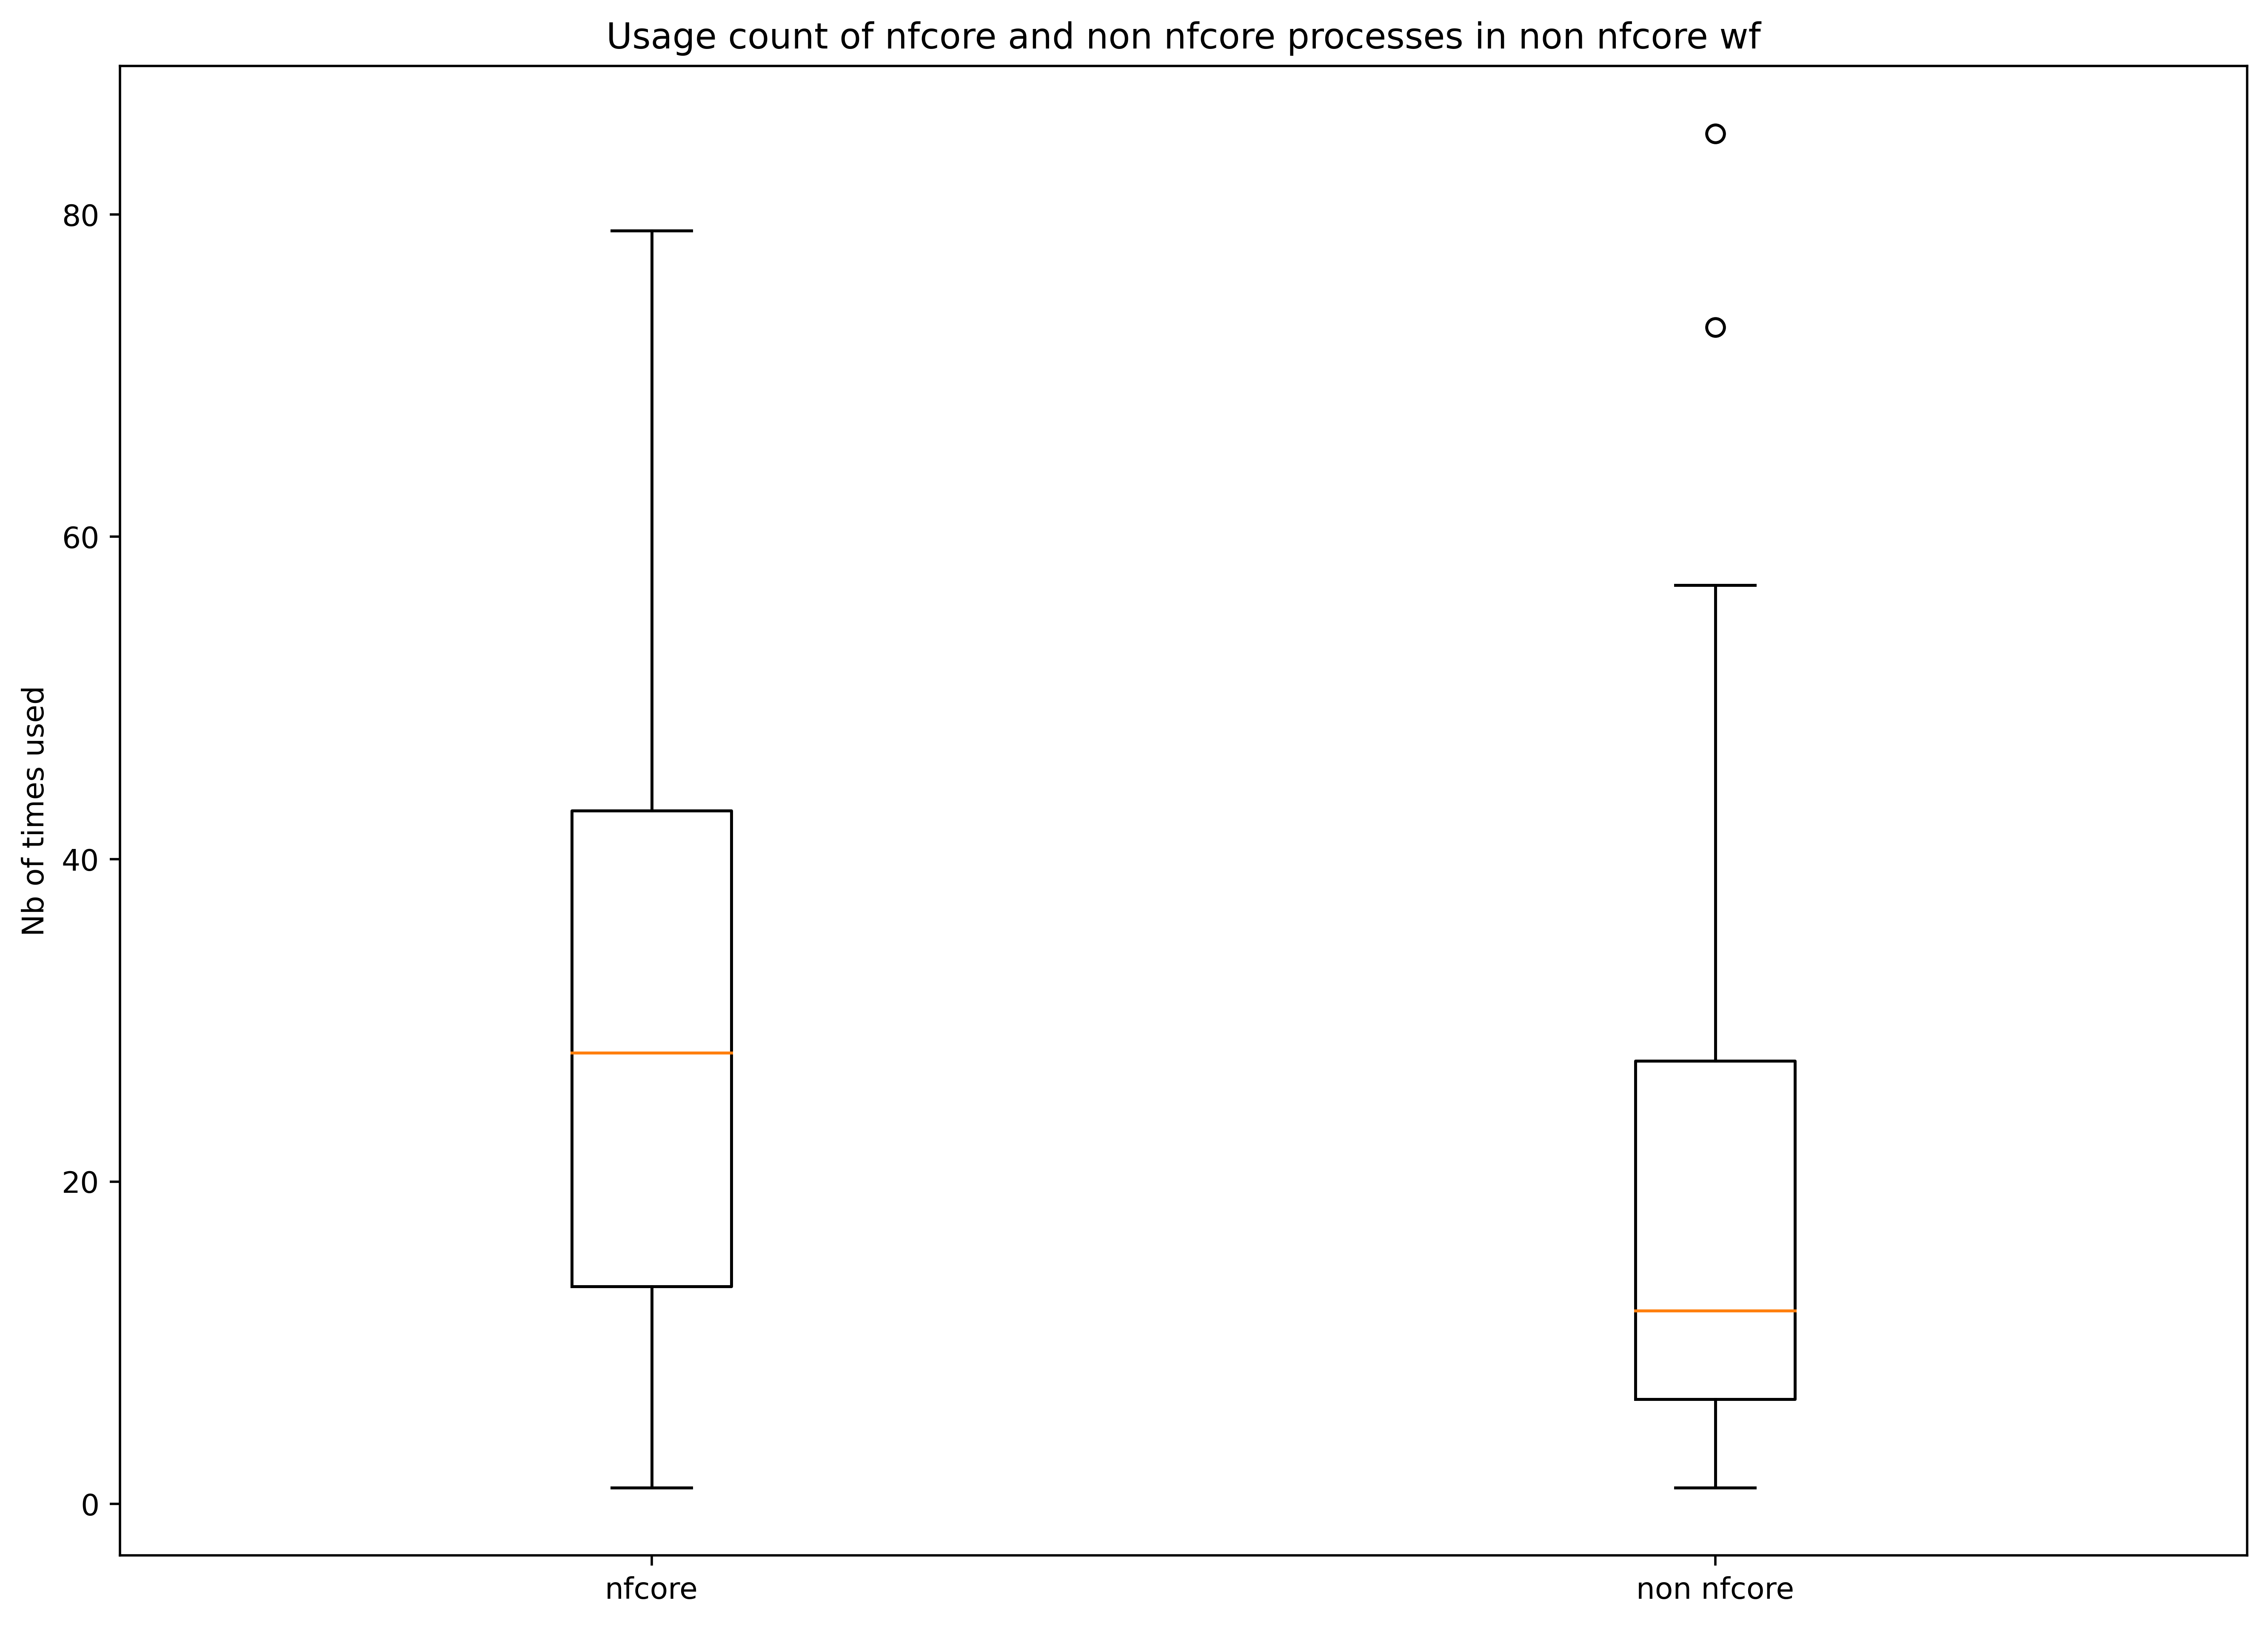

In [35]:
make_boxplot_nfc(df_nf_lev_nfc,df_nf_lev_non_nfc)

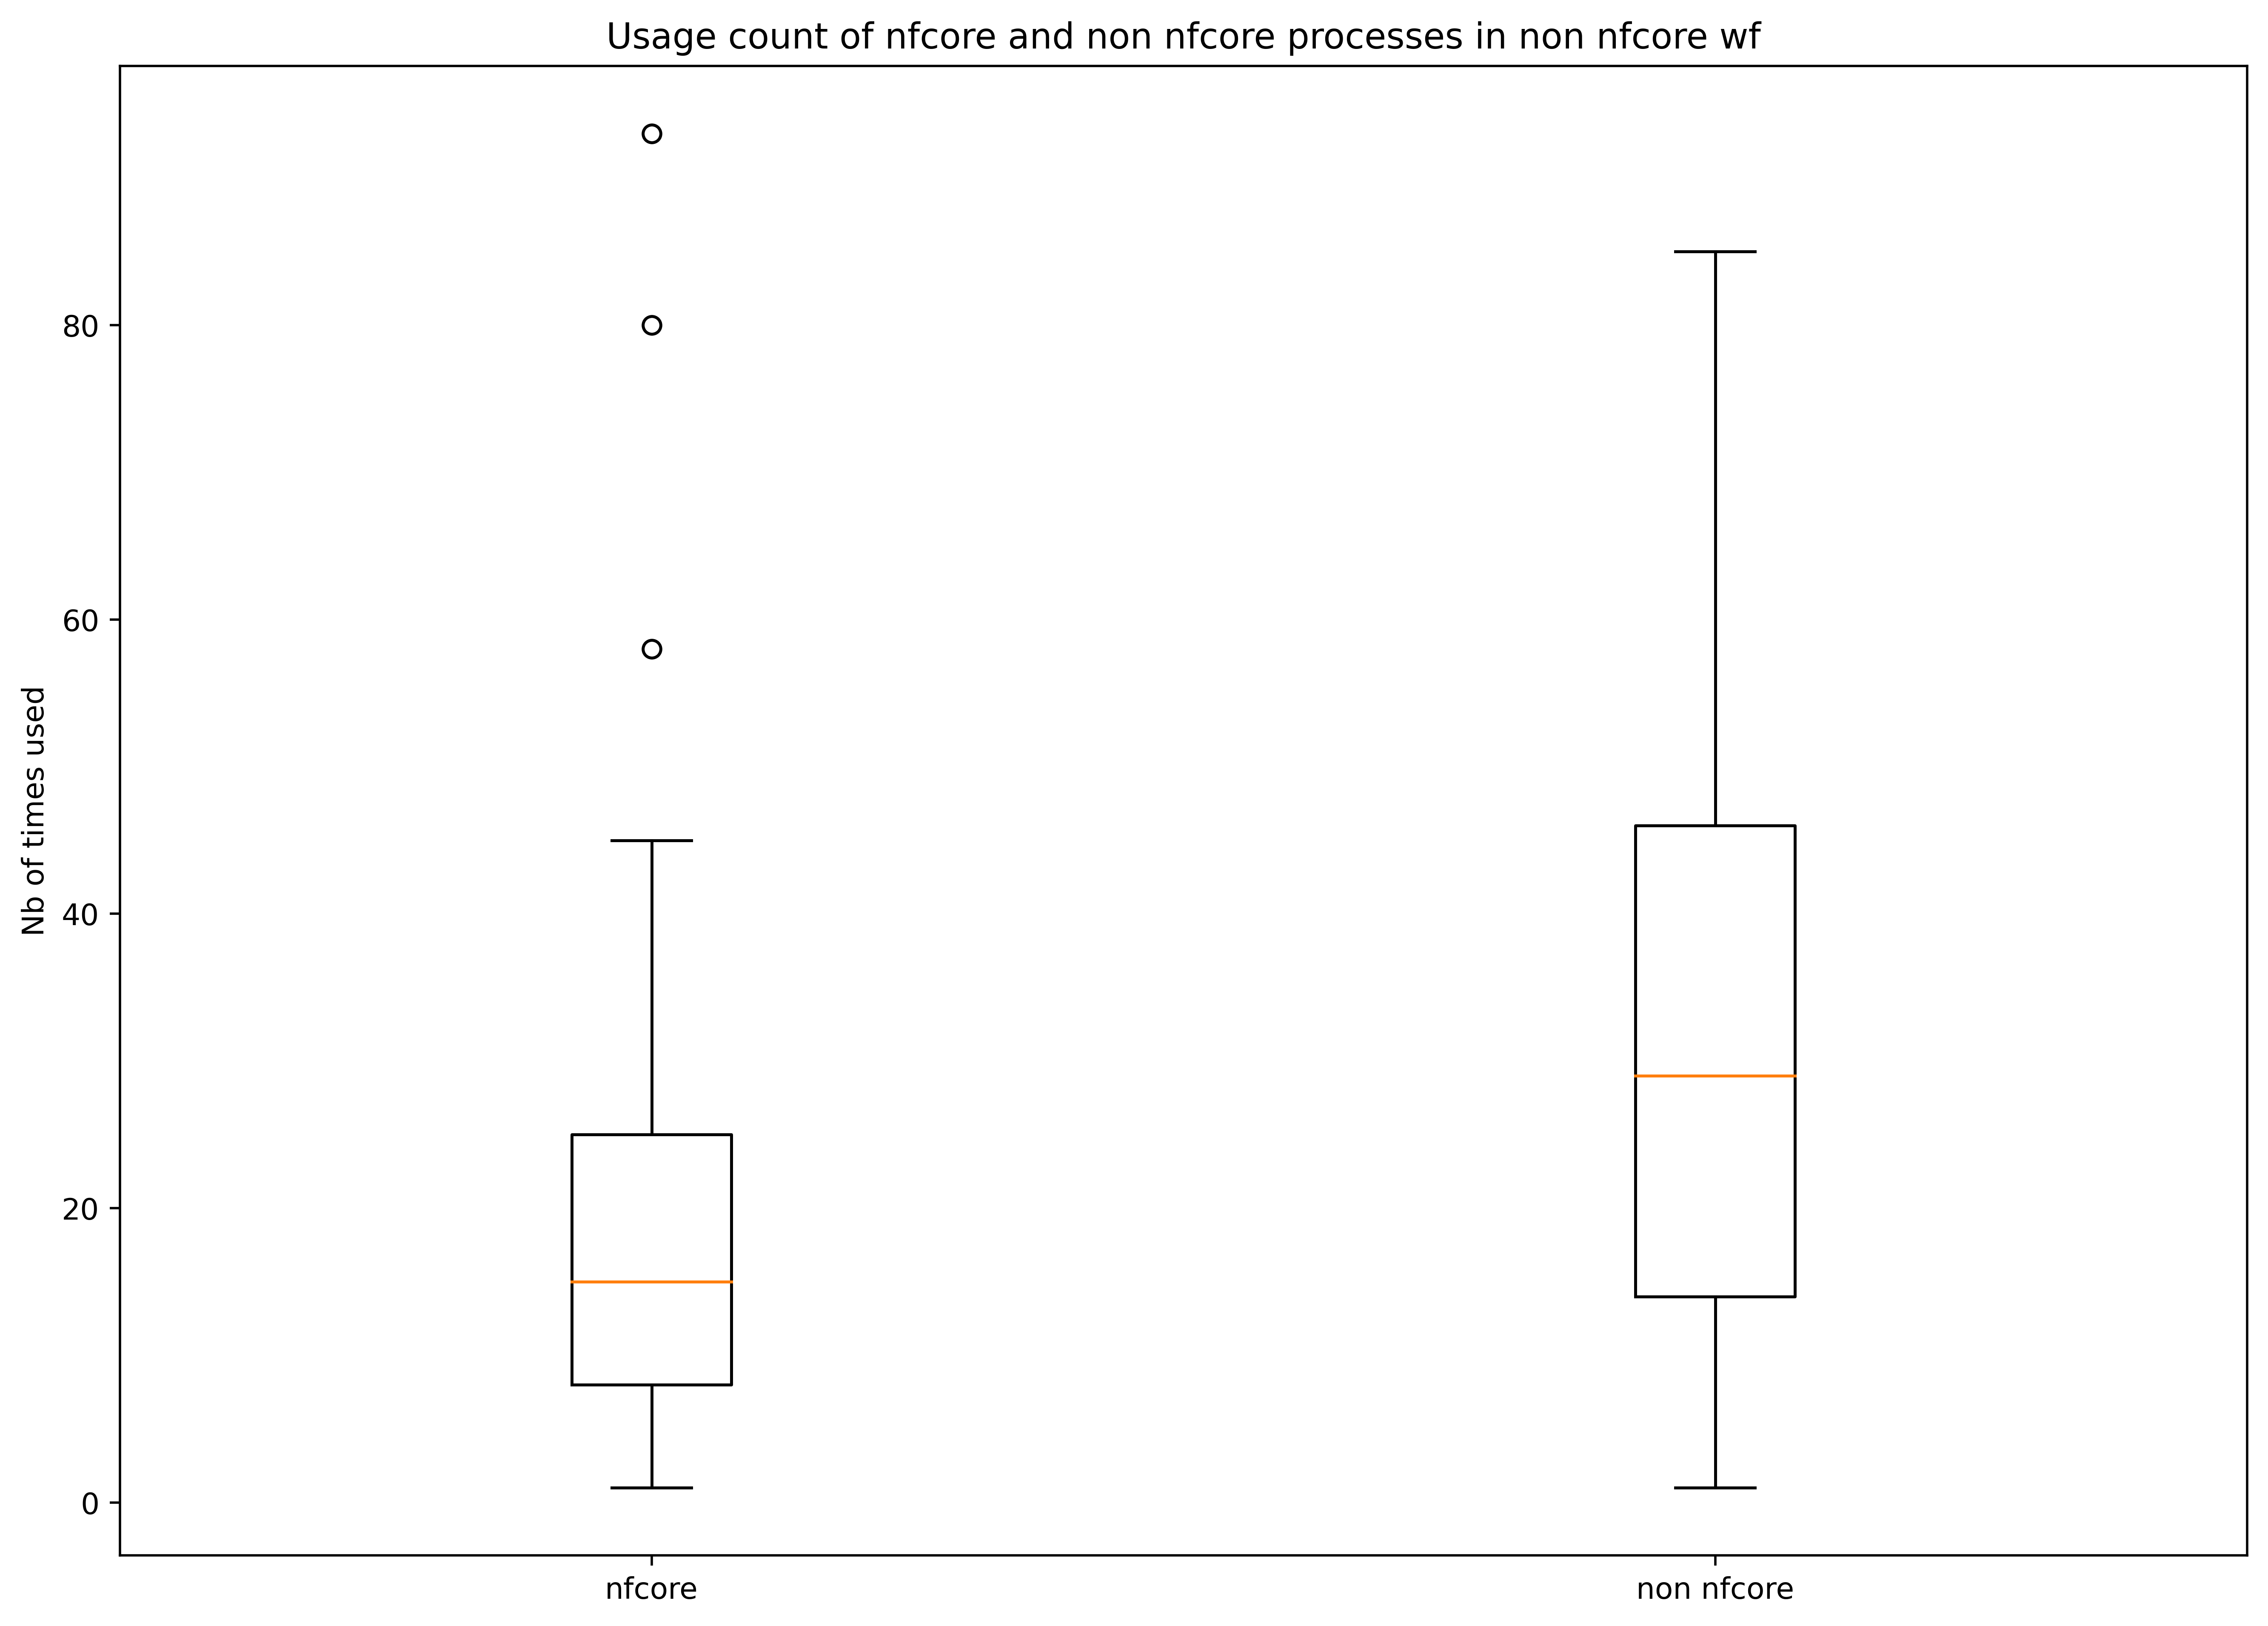

In [36]:
make_boxplot_nfc(df_snk,df_nf)

In [45]:
max(df_nf_proc["nb_reuse"])

85

In [50]:
i=0
for proc in nf_json:
    if proc["nb_reuse"]==2:
        p = proc
        print(i)
        cnt = 0
        for el in p["list_wf"]:
            if 'utorial' in el:
                cnt+=1
        print(cnt)
    i+=1

13
0
16
0
30
0
33
0
38
0
54
0
69
0
99
0
123
0
128
0
130
0
157
0
158
0
178
0
190
0
199
0
200
0
201
0
202
0
204
0
211
0
223
0
226
0
227
0
230
0
232
0
234
0
237
0
240
0
250
0
256
0
259
0
300
0
301
0
303
0
325
0
326
0
327
0
330
0
331
0
332
0
333
0
336
0
339
0
347
0
348
0
349
0
351
0
354
0
355
0
356
0
358
0
359
0
360
0
387
0
388
0
389
0
390
0
391
0
392
0
393
0
394
0
395
0
396
0
397
0
399
0
400
0
401
0
403
0
404
0
405
0
406
0
407
0
408
0
409
0
410
0
411
0
412
0
413
0
414
0
415
0
416
0
417
0
418
0
419
0
420
0
421
0
422
0
423
0
424
0
425
0
426
0
427
0
428
0
429
0
430
0
431
0
432
0
433
0
434
0
435
0
436
0
445
0
447
0
448
0
450
0
451
0
452
0
453
0
454
0
455
0
472
0
478
0
485
0
491
0
520
0
525
0
541
0
585
0
592
0
593
0
594
0
595
0
597
0
600
0
601
0
603
0
610
0
612
0
627
0
644
0
649
0
660
0
661
0
662
0
663
0
664
0
665
0
666
0
667
0
668
0
669
0
674
0
700
0
709
0
710
0
711
0
776
0
819
0
829
0
854
0
856
0
860
0
862
0
863
0
864
0
865
0
866
0
867
0
868
0
869
0
870
0
871
0
872
0
876
0
877
0
878
0
879
0


4

In [23]:
df_nf_lev_nfc.head()

,Unnamed: 0,nb_reuse,nb_proc,prop_proc,nb_own,prop_own,nb_wf,prop_wf,prop_proc_nfc
0,0,1.0,121.0,2.60271,145.0,3.11895,126.0,2.71026,2.60271
1,1,2.0,77.0,1.65627,78.0,1.67778,77.0,1.65627,1.65627
2,2,3.0,31.0,0.66681,33.0,0.70983,36.0,0.77436,0.66681
3,3,4.0,23.0,0.49473,35.0,0.75285,23.0,0.49473,0.49473
4,4,5.0,29.0,0.62379,36.0,0.77436,31.0,0.66681,0.62379


In [21]:
df_tot_nfc=make_df_tot_nfc(df_nf_lev_nfc,df_nf_lev_non_nfc,"nb_reuse")
df_tot_nfc_wf=make_df_tot_nfc(df_nf_lev_nfc,df_nf_lev_non_nfc,"nb_wf")


In [22]:
df_tot_nfc.head()

,nb_reuse,prop_proc_nfc,prop_proc_non_nfc
0,1.0,2.60271,65.390407
1,2.0,1.65627,12.239191
2,3.0,0.66681,3.377070
3,4.0,0.49473,1.828350
4,5.0,0.62379,0.924930


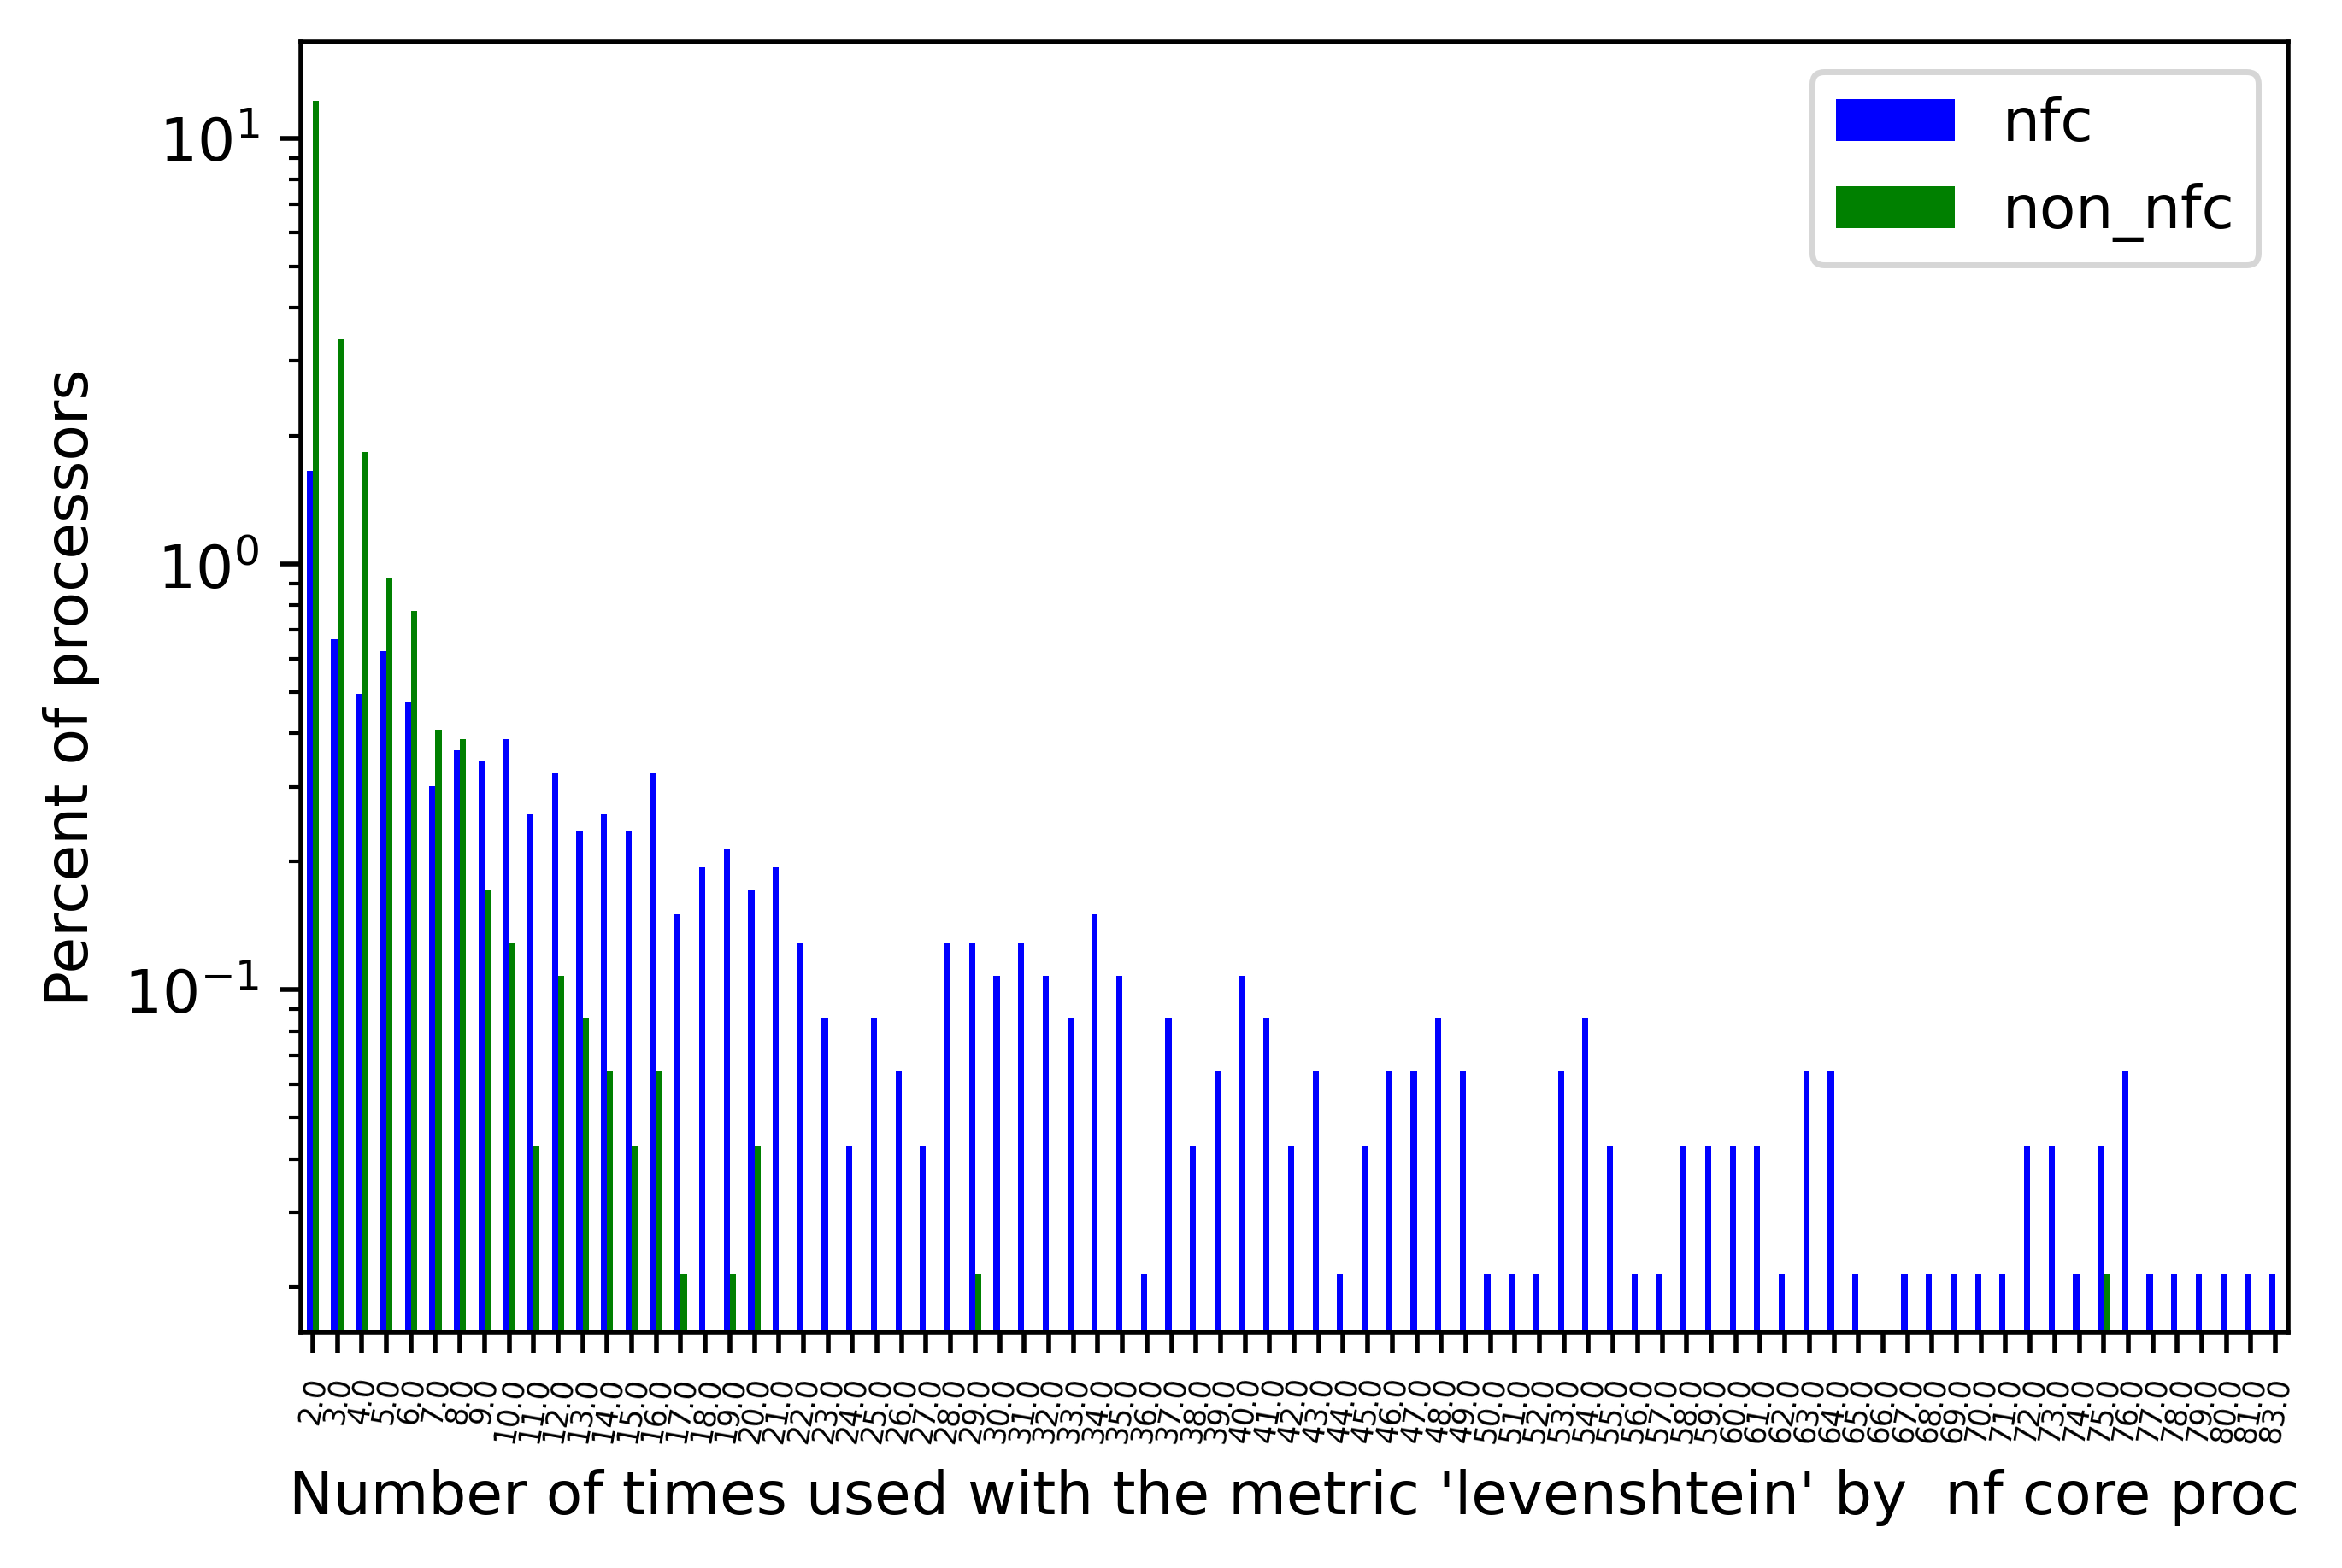

In [23]:
fig = disp_fig_props_nfc(df_tot_nfc," nf core proc","processors")

In [24]:
df_nf_nfc_proc.head()

,nb_reuse,tools,nb_own,list_own,nb_wf,list_wf,list_contrib,nb_contrib,codes,list_proc,list_wf_names
0,3,"[SAMtools, Minimap2]",3,"[ABMicroBioinf, nf-core, ksumngs]",3,"[modules, magph, nf-modules]","[nebfield, sruthipsuresh, tamara-hodgetts, ful...",106,"[process MINIMAP2_ALIGN {\n tag ""$meta.id""\...","[ABMicroBioinf/magph/ABMicroBioinf__magph, nf-...","[ksumngs/nf-modules, nf-core/modules, ABMicroB..."
1,4,"[FastQC, GATK, SAMtools, GOstats, MetaPhlAn]",4,"[ABMicroBioinf, nf-core, xiaoli-dong, jianhong]",3,"[shotgun, modules, magph]","[nebfield, sruthipsuresh, tamara-hodgetts, ful...",106,"[process GATK4_MERGEMUTECTSTATS {\n tag ""$m...","[nf-core/modules/nf-core__modules, ABMicroBioi...","[jianhong/shotgun, nf-core/modules, xiaoli-don..."
2,14,"[snpEff, iview, fastPHASE, MMseqs, BWA, ALIGN,...",10,"[ABMicroBioinf, raygozag, cidgoh, mahesh-panch...",12,"[rnavar, magph, rnaseq, nf-core-hicar, test_nf...","[zxl124, m3hdad, jordwil, drpowell, csawye01, ...",83,"[process STRINGTIE_STRINGTIE {\n tag ""$meta...","[nf-core/rnaseq/nf-core__rnaseq, mahesh-pancha...","[harryscholes/giga, raygozag/rnaseq, nf-core/v..."
3,7,"[Rbowtie2, Picard, Racon, BCFtools, SAMtools, ...",5,"[ABMicroBioinf, mahesh-panchal, nf-core, jianh...",7,"[magph, mycosnp-nf, test_nfcore_workflow_chain...","[nebfield, sruthipsuresh, tamara-hodgetts, ful...",118,"[process BOWTIE2_ALIGN {\n tag ""$meta.id""\n...",[mahesh-panchal/test_nfcore_workflow_chain/mah...,"[nf-core/viralrecon, mahesh-panchal/test_nfcor..."
4,36,"[CoreSlicer, BAIT, RAxML-NG, Flipper, fastPHAS...",21,"[LNUc-EEMiS, vincenthhu, Mxrcon, dthorburn, bi...",32,"[raredisease, shotgun, nf-fastp, nf-core-platy...","[phoenixAja, nebfield, sruthipsuresh, alneberg...",157,"[process FASTQC {\n tag ""$meta.id""\n lab...","[jianhong/shotgun/jianhong__shotgun, nf-core/n...","[nf-core/exoseq, nf-core/nascent, CDCgov/mycos..."


In [25]:
df_nf_nfc_proc=df_nf_nfc_proc.sort_values(by=["nb_reuse"], ascending=False)
df_nf_nfc_proc = df_nf_nfc_proc.reset_index(drop=True)
df_nf_non_nfc_proc=df_nf_non_nfc_proc.sort_values(by=["nb_reuse"], ascending=False)
df_nf_non_nfc_proc = df_nf_non_nfc_proc.reset_index(drop=True)

df_nf_nfc_proc["index"]=df_nf_nfc_proc.index
df_nf_nfc_proc["nb_reuse_nfc"]=df_nf_nfc_proc["nb_reuse"]
df_nf_non_nfc_proc["index"]=df_nf_non_nfc_proc.index
df_nf_non_nfc_proc["nb_reuse_non_nfc"]=df_nf_non_nfc_proc["nb_reuse"]

In [26]:
df_nfc_tot = pd.merge(df_nf_nfc_proc[["index","nb_reuse_nfc"]],df_nf_non_nfc_proc[["index","nb_reuse_non_nfc"]],on="index",how="outer")
df_nfc_tot = df_nfc_tot.fillna(0)


In [27]:
df_nfc_tot.head()

,index,nb_reuse_nfc,nb_reuse_non_nfc
0,0,83.0,75
1,1,81.0,29
2,2,80.0,20
3,3,79.0,20
4,4,78.0,19


In [53]:
cnt = 0
for el in nf_proc:
    if 'utorial' in el["wf_orig"]:
        cnt+=1
cnt

25

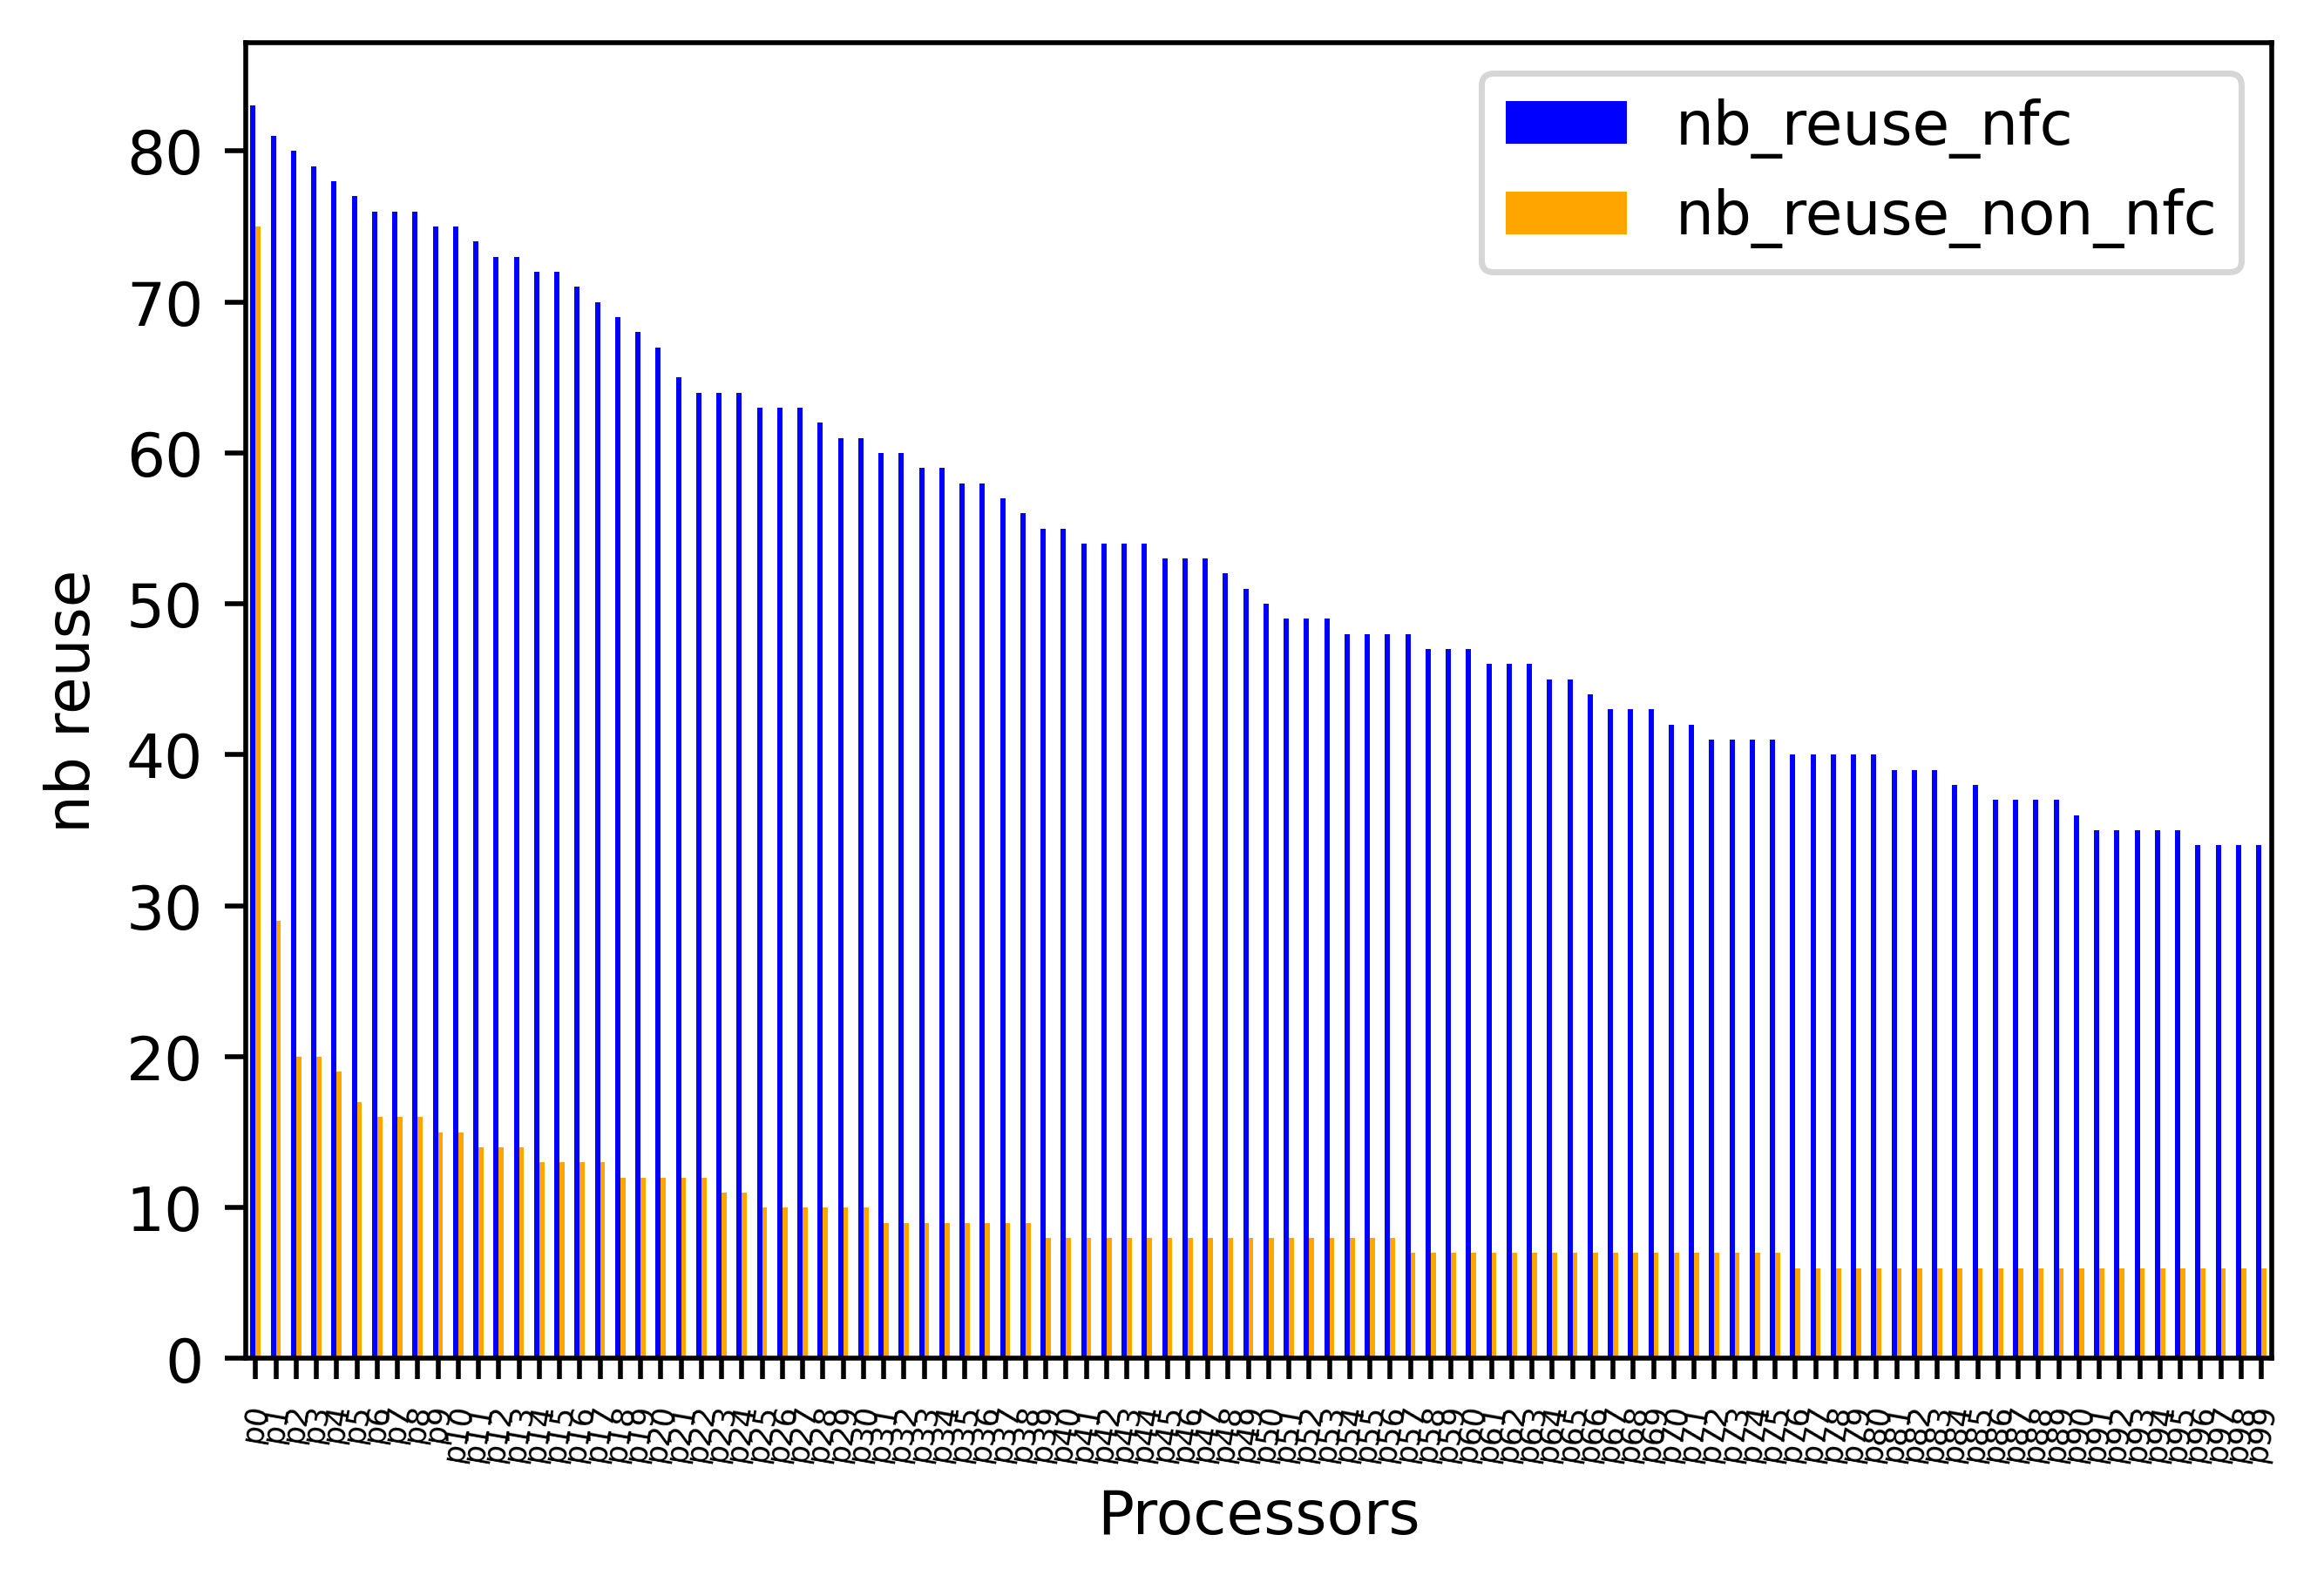

In [28]:
n=100
df_to_plot=df_nfc_tot[["nb_reuse_nfc","nb_reuse_non_nfc"]].head(n)
fig = df_to_plot.plot( kind="bar", color = ['blue','orange'], label = ['nfc','non_nfc'])
l = ["p"+str(i) for i in range(0,n)]
fig.set_xticklabels(l, rotation=80, size=5)
fig.set_xlabel("Processors")
fig.set_ylabel('nb reuse')
fig.legend(loc='best')
#fig.set_yscale('log')
plt.show()
plt.rcParams['figure.dpi'] = 500
plt.rcParams['savefig.dpi'] = 500


In [29]:
df_nfc_tot[["nb_reuse_nfc","nb_reuse_non_nfc"]].head()

,nb_reuse_nfc,nb_reuse_non_nfc
0,83.0,75
1,81.0,29
2,80.0,20
3,79.0,20
4,78.0,19


In [30]:
nb_reuse=75
for el in nf_non_nfc_json:
    if(el["nb_reuse"]==nb_reuse):
        el_select=el

In [31]:
el_select

{'nb_reuse': 75,
 'tools': ['MultiQC'],
 'nb_own': 49,
 'list_own': ['biocorecrg',
  'genomic-medicine-sweden',
  'MaxGreil',
  'jiangweiyao',
  'nextflow-io',
  'porchard',
  'Mxrcon',
  'hugovaysset',
  'pditommaso',
  'UMCUGenetics',
  'telatin',
  'icbi-lab',
  'michaelbale',
  'mingxinliu',
  'zamanianlab',
  'PI-Bioinfo',
  'likelet',
  'alperyilmaz',
  'h3abionet',
  'lucacozzuto',
  'galaxyuvri-ea',
  'gavinf97',
  'cbcrg',
  'grbot',
  'codingene',
  'vibbits',
  'shaunchuah',
  'UnseenBio',
  'chrstphdm',
  'antunderwood',
  'grpiccoli',
  'clairecoleman1',
  'pilm-bioinformatics',
  'maxibor',
  'supark87',
  'cmatKhan',
  'czbiohub',
  'genomicsITER',
  'edg1983',
  'drejom',
  'tobsecret',
  'kevinpryan',
  'mvanins',
  'lifebit-ai',
  'hirenbioinfo',
  'bunop',
  'oisinmccaffrey',
  'kviljoen',
  'ggrimes'],
 'nb_wf': 64,
 'list_wf': ['Nextflow-study',
  'PHIND_course_nextflow_Feb_2022',
  'rtp_workshop',
  'SIB_course_nextflow_Nov_2021',
  'NextflowModules',
  'RNAseq-Ne

In [32]:
nb_reuse=83
for el in nf_nfc_json:
    if(el["nb_reuse"]==nb_reuse):
        el_select=el

In [33]:
len(el_select['tools'])

52

In [34]:
el_select.keys()

dict_keys(['nb_reuse', 'tools', 'nb_own', 'list_own', 'nb_wf', 'list_wf', 'list_contrib', 'nb_contrib', 'codes', 'list_proc', 'list_wf_names'])

In [35]:
el_select["list_wf_names"]

['BioinformaticsLabAtMUN/sRNACharP',
 'Vikash84/viclara',
 'tamara-hodgetts/nf-atac-seq',
 'gates-mri-bioinformatics/reference-database',
 'luslab/luslab-nf-modules',
 'quinlan-lab/preon',
 'egenesis/WF-NF-rnassembly',
 'peterk87/nf-cleanplex-preprocess',
 'Paul-rk-cruz/HRV_Pipeline',
 'asafpr/sRNA_finder',
 'bioinfo-pf-curie/annotationMaker',
 'monikaBrandt/nf-core-mynewpipeline',
 'cimendes/metaFlow',
 'eQTL-Catalogue/genimpute',
 'NCBI-Hackathons/Nasty_Metagenomes',
 'gis-rpd/rpd-sg10k-grch38-gatk4-gvcf-freebayes-vcf',
 'mikek498/artic-gls',
 'biocorecrg/transcriptome_assembly',
 'guigolab/sambamBench-nf',
 'h3abionet/chipimputation_evaluate_chips',
 'czbiohub/nf-predictorthologs',
 'biocorecrg/BioNextflow',
 'qbic-pipelines/vcreport',
 'kingzhuky/meripseqpipe',
 'microgenlab/porefile',
 'AlexVCaron/mrHARDIflow',
 'biocorecrg/nf-cloud-gpu-test',
 'cometsong/ATAC_Seq_nxf',
 'bioinfo-pf-curie/as-mapping',
 'ncsa/GenomicsCortextVarNextflow',
 'Akazhiel/NeoPred-NF',
 'mblanche/nextflow'